# Parameter Tuning
---

## [Part 1. Learning Rate Tuning](#part-1) 

## [Part 2. Regularization hyperparameter Tuning](#part-2)

## [Part 3. Model without Normalization](#part-3)

## [Conclusion](#conclusion)

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import warnings
from tqdm import tqdm 

In [4]:
# Ignore Warnings 
warnings.filterwarnings("ignore")

#to see all the columns
pd.set_option('display.max_columns',30) 

### Read Data 

In [5]:
# Load datasets
train = pd.read_csv("./data/filtered_train.csv")
dev = pd.read_csv("./data/filtered_dev.csv")

In [6]:
train.head()

,dummy,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,price,month,day,year
0,1,4,2.50,10006,2.0,0,0,3,9,2720,0,1989,0,98074,47.6295,-122.042,2720,5.9495,7,9,2014
1,1,2,2.50,5000,1.0,0,0,5,8,1300,1300,1926,0,98126,47.5806,-122.379,2260,6.6500,7,18,2014
2,1,5,1.75,3000,1.5,0,0,3,8,1650,0,1902,0,98144,47.5955,-122.306,1740,4.4300,7,7,2014
3,1,4,1.75,9600,1.0,0,0,4,8,1720,0,1969,0,98059,47.4764,-122.155,1660,3.8000,4,28,2015
4,1,6,2.25,11180,1.0,0,2,5,9,2440,1390,1962,0,98008,47.5849,-122.113,2500,8.8700,9,4,2014


In [7]:
train.columns

Index(['dummy', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'price',
       'month', 'day', 'year'],
      dtype='object')

In [8]:
# Global parameters
eps = 0.5
np.random.seed(2)

In [9]:
## Normalization
# We save copies of the non normalized datasets for part 4 : Impact of Normalization
train_raw = train.copy()
dev_raw = dev.copy()

In [10]:
# making sure we have numerical features are float:
for df in [train_raw,dev_raw]:
    for col in df.columns:
        df[col] = df[col].map(float)

### Normalization

__Max-min Normalization__ is used to normalize all input feature as well as prediction (price).

normalized_values = (raw_value - min) / (max - min)

There are multiple ways to normalize the value. Most common is standardization method. But we are exploring Max-Min normalization method here.

In [11]:
cols = list(train.columns)

# dummy and price are removed from normalization
cols.remove('price')
cols.remove('dummy')

for col in cols:
    M = train[col].max()
    m = train[col].min()
    train[col] = train[col].map(lambda x : (x-m)/(M-m))
    dev[col] = dev[col].map(lambda x : (x-m)/(M-m))
    
M = train.price.max()
m = train.price.min()

train['normalized_price'] = train.price.map(lambda x : (x-m)/(M-m))

 <a name="part-1"> <h1> 
Part 1. Learning Rate Tuning </h1> </a>

In this part, Learning rate is tunned. Learning rate is step size at which weights are updated. The usal value various between [0,1] .

The learning rate were choose from : [1e-0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]

In [14]:
def learn(train,dev,gamma,max_it,lambdA):
    t = time.time()
    
    # y : normalized  price, used for learing purpose 
    # y_raw : Not Normalized price, used for computing error purpose
    y = np.transpose(np.array(train.normalized_price,ndmin=2))
    y_raw = np.transpose(np.array(train.price,ndmin=2))
    
    
    X = np.array(train.drop(['price','normalized_price'],axis=1))
    X_dev = np.array(dev.drop('price',axis=1))
    features = list(train.drop(['price','normalized_price'],axis=1).columns)
    
    N = X.shape[0] # total number of examples
    d = X.shape[1] # number of input features
    w = np.random.rand(d,1) # to store weights
    
    RMSE_train = [] # collect RMSE value for each iteration
    RMSE_dev = [] # collect RMSE value for each iteration
    c = 0 # count iteration
    
    norm_grad = 100 
    
    while (norm_grad > eps) & (c < max_it):
        error = X.dot(w) - y
        grad = 2*np.transpose(X).dot(error)+2*lambdA*w
        norm_grad = np.linalg.norm(grad)
        w -= gamma*grad
        RMSE_train.append(np.linalg.norm(((X.dot(w))*(M-m)+m) - y_raw)/N)
        c += 1
        # SSE validation :
        y_dev = np.transpose(np.array(dev.price,ndmin=2))
        
        RMSE_dev.append(np.linalg.norm(((X_dev.dot(w))*(M-m)+m) - y_dev)/N)

    # Mean Relative Absolute Error on validation :
    MRAE = np.round((pd.Series((((X_dev.dot(w))*(M-m)+m) - y_dev)[:,0]).map(abs)/dev.price).mean(),4)
    elapsed=time.time()-t
    return (w,c,elapsed,RMSE_train,RMSE_dev,MRAE,features)

In [22]:
lambdA = 0 # no L2 regression

max_it = 500000 # we tried with 1M5 for 1e-7 but norm_grad won't get lower

gammas = [1e-0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]

all_c = [] # to store number of iteration for each case

RMSEs_train = [] # sum of sq  of error on train set
RMSEs_validation = [] # sum of sq  of error on dev set

all_MRAE = [] # Mean Relative Absolute Error on validation for each case

SSE_train_curves = []
all_w = [] # Weights or learned coefficent of each features


for gamma in tqdm(gammas):
    w,c,elapsed,RMSE_train,RMSE_dev,MRAE,features = learn(train,dev,gamma,max_it,lambdA)
    all_c.append(c)
    RMSEs_train.append(RMSE_train[-1])
    RMSEs_validation.append(RMSE_dev[-1])
    all_MRAE.append(MRAE)
    all_w.append(w)        

100%|██████████| 8/8 [01:54<00:00, 14.28s/it]


In [24]:
results_part = pd.DataFrame({'Gamma':gammas,'iterations':all_c,'RMSE training':RMSEs_train,\
             'RMSE validation':RMSEs_validation,'MRAE':all_MRAE})

In [26]:
results_part

,Gamma,iterations,RMSE training,RMSE validation,MRAE
0,1.000000e+00,65,NaN,NaN,NaN
1,1.000000e-01,82,NaN,NaN,NaN
2,1.000000e-02,110,NaN,NaN,NaN
3,1.000000e-03,169,NaN,NaN,NaN
4,1.000000e-04,399,NaN,NaN,NaN
5,1.000000e-05,5193,0.017179,0.016227,0.2317
6,1.000000e-06,60921,0.017179,0.016230,0.2317
7,1.000000e-07,500000,0.017179,0.016224,0.2317


In [28]:
# Learning weights from the best solution :
# the one from gamma = 1e-5
weights = pd.DataFrame({'Features':features,'Weights':list(all_w[5][:,0])})
weights = weights.sort_values(by='Weights',ascending=False)
weights

,Features,Weights
8,grade,0.275485
9,sqft_above,0.145877
14,lat,0.126447
5,waterfront,0.124426
6,view,0.072161
2,bathrooms,0.060363
10,sqft_basement,0.055274
16,sqft_living15,0.049825
7,condition,0.048317
4,floors,0.022501


 <a name="part-2"> <h1> 
Part 2. Lambda Tuning </h1> </a>

In [36]:
## Part 2 :
max_it = 300000
gamma = 1e-5
lambdas = [0,1e-3,1e-2,1e-1,1,10,100]
RMSEs_train = []
RMSEs_validation = []
ws = []
all_MRAE=[]
for lambdA in tqdm(lambdas):
    w,c,elapsed,RMSE_train,RMSE_dev,MRAE,features = learn(train,dev,gamma,max_it,lambdA)
    RMSEs_train.append(RMSE_train[-1])
    RMSEs_validation.append(RMSE_dev[-1])    
    ws.append(w)
    all_MRAE.append(MRAE)

100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


In [38]:
results_part2 = pd.DataFrame({'Lambda':lambdas,'RMSE training':RMSEs_train,\
             'RMSE validation':RMSEs_validation,'MRAE':all_MRAE})
results_part2

,Lambda,RMSE training,RMSE validation,MRAE
0,0.000,0.017179,0.016230,0.2317
1,0.001,0.017179,0.016227,0.2317
2,0.010,0.017179,0.016232,0.2317
3,0.100,0.017179,0.016233,0.2318
4,1.000,0.017179,0.016236,0.2314
5,10.000,0.017209,0.016354,0.2286
6,100.000,0.017997,0.017452,0.2274


### best scored lambda and learning rate

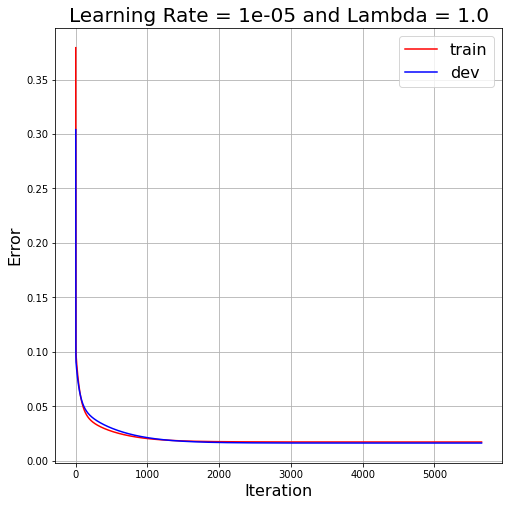

<Figure size 432x288 with 0 Axes>

In [66]:
gamma=1e-5
lambdA =1.0
w,c,elapsed,RMSE_train,RMSE_dev,MRAE,features = learn(train,dev,gamma,max_it,lambdA)
plt.figure(figsize=(8,8))
plt.title('Learning Rate = '+str(gamma)+' and Lambda = '+str(lambdA), fontsize=20)
plt.plot(RMSE_train,'-r',label='train')
plt.plot(RMSE_dev,'-b',label='dev')
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Error',fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()
plt.savefig('./images/learning_curve.png')

In [67]:
results = pd.DataFrame({'Learning Rate ':gamma,'lambda ':lambdA,'RMSE training ':RMSE_train[-1],
             'RMSE validation ':RMSE_dev[-1],'MRAE ':MRAE},index=[0])
results

,Learning Rate,lambda,RMSE training,RMSE validation,MRAE
0,0.00001,1.0,0.017179,0.016243,0.2313


<a name="part-3"> <h1> 
Part 3. Regression model without Normalization </h1> </a>

<b style="font-size:20px">Research Question : How Normalization impacts model performance? </b>

Normalization of input features helps model to learn faster and improve performance of the model. In this par, we check whether normalization has any impact or not. 


In [68]:
def learn_part3(train,dev,gamma,max_it,lambdA):
    y = np.transpose(np.array(train.price,ndmin=2))
    X = np.array(train.drop(['price','normalized_price'],axis=1))
    N = X.shape[0]
    d = X.shape[1]
    w = np.random.rand(d,1)
    norm_grad = 100
    RMSE_train = []
    RMSE_dev = []
    c = 0
    while (norm_grad > eps) & (c < max_it):
        error = X.dot(w) - y
        grad = 2*np.transpose(X).dot(error) + 2*lambdA*w
        norm_grad = np.linalg.norm(grad)
        w -= gamma*grad
        RMSE_train.append(np.linalg.norm(X.dot(w) - y)/N)
        c += 1
        # SSE validation :
        y_dev = np.transpose(np.array(dev.price,ndmin=2))
        X_dev = np.array(dev.drop('price',axis=1))
        RMSE_dev.append(np.linalg.norm(X_dev.dot(w) - y_dev)/N)
    MRAE = np.round((pd.Series(((X_dev.dot(w)) - y_dev)[:,0]).map(abs)/dev.price).mean(),4)
        
    return (w,RMSE_train,c,RMSE_dev,MRAE)

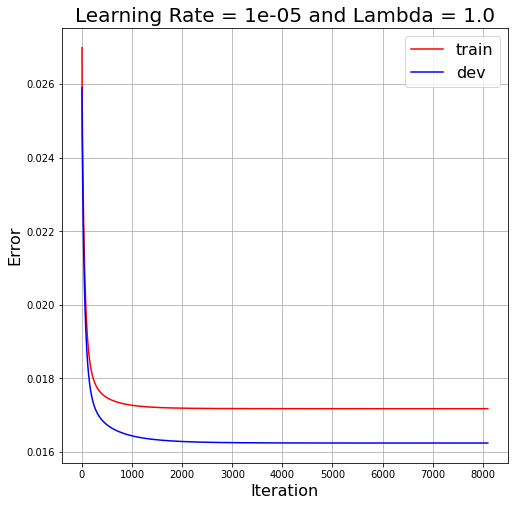

<Figure size 432x288 with 0 Axes>

In [69]:
max_it = 10000
gammas = 1e-5
lambdA =1.0

w,RMSE_train,c,RMSE_dev,MRAE = learn_part3(train,dev,gamma,max_it,lambdA)

plt.figure(figsize=(8,8))
plt.title('Learning Rate = '+str(gamma)+' and Lambda = '+str(lambdA), fontsize=20)
plt.plot(RMSE_train,'-r',label='train')
plt.plot(RMSE_dev,'-b',label='dev')
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Error',fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

plt.savefig('./images/learning_curve_raw.png')


In [70]:
results = pd.DataFrame({'Learning Rate':gamma,'Lambda':lambdA,' RMSE training ':RMSE_train[-1],
             ' RMSE validation ':RMSE_dev[-1],' MRAE ':MRAE},index=[0])
results

,Learning Rate,Lambda,RMSE training,RMSE validation,MRAE
0,0.00001,1.0,0.017179,0.016246,0.2314


<a name="conclusion"> <h1> 
Conclusion </h1> </a>

    
__1:__ Learning rate 1e-5 and Lambda 1.0 are found to be optimum. 

__2:__ No significant difference is observed in model's RMSE with and without normalization. However, with normalization model learn faster than without normalization.   
